#### Introduction
First of all, having consumed my one year free-trial on Google Cloud Platform (so I couldn't extract TTC using it, and due to my current internship I wouldn't have had time to label the data). \\
What have I done ? I found an almost-same dataset on GitHub (https://github.com/clovaai/cord), link to the paper: https://openreview.net/pdf?id=SJl3z659UH \\
Tha main points in this notebook are : \\
<!-- * Downloading and unzipping files directly in Google Drive (care for limited drive size, unzipped train and test files have a size of approximately 2 GB). -->
* Extracting ROI (TTC) bounding boxes from JSON files.
* Resizing all the images to 1296x864 resolution (the most common resolution in the dataset), and I transformed them to channel-first format (for PyTorch conveniance) and reduced the pixels to 0-1 scale.
* The model used is a Faster R-CNN with a ResNet-50 FPN backbone trained from scratch.
* I didn't use Cross-Validation to keep everything simple, I just trained on train data and validated on the test set.
* Some files are taken from Torchvision's GitHub repository (MS-Coco segmentation and prediction part).
* *Good coders borrow, great coders steal*.

**Data** can be copied from this [link](https://drive.google.com/drive/folders/1_r2rgPKBqqFmEFoNvz2lQGfIIfRALJ_W) to your personal Drive.

for myself I created a directory named youngapp and moved data into youngapp/data


---



#### Imports and drive mounting

In [ ]:
%matplotlib inline
import torch
import copy
import numpy as np
import torch.nn.functional as F
from time import time
import glob
import json
from datetime import datetime
from google.colab import drive
from IPython.display import Image, display
from PIL import Image as Im
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.patches import Patch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Move to project directory (containing data and suplementary files)


In [ ]:
cd 'drive/My Drive/youngapp'

/content/drive/My Drive/youngapp


In [ ]:
# import suplementary files (modified from Torchvision repository)
from engine import train_one_epoch, evaluate

####Little EDA

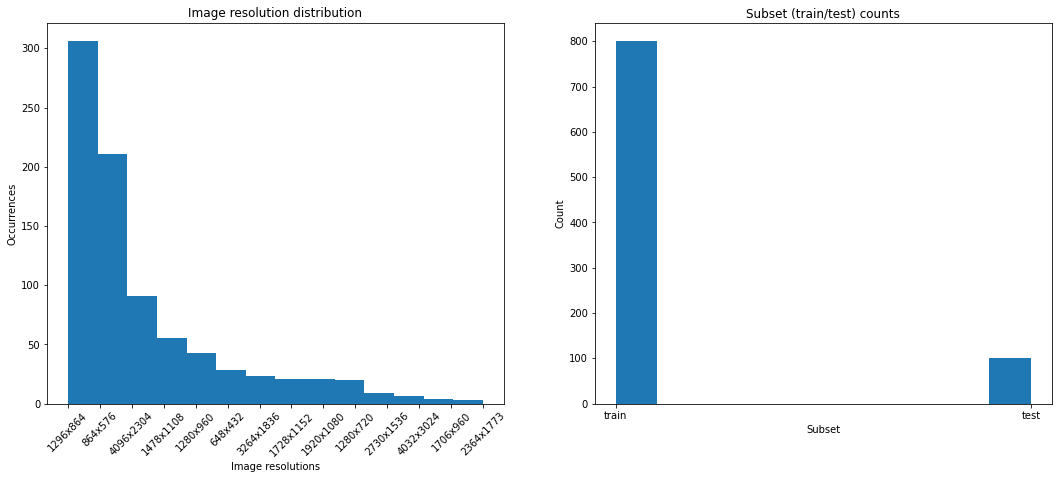

In [ ]:
shapes = {}

# count both train and test images
train_files = list(glob.glob('data/train/image/*.png')) 
test_files = list(glob.glob('data/test/image/*.png'))
files = train_files + test_files

for img in files:
  img = Im.open(img)
  if img.size in shapes.keys():
    shapes[img.size] += 1
  else:
    shapes[img.size] = 1

fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# get only shapes with more of 2 occurrences and sort them be descending order
shapes = dict(filter(lambda elem: elem[1] > 2, shapes.items())) 
shapes = dict(sorted(shapes.items(), key=lambda item: item[1], reverse=True))

# get resolutions in Height X Width format
xticks = [f'{res[1]}x{res[0]}' for res in shapes.keys()] 

# plot resolutions histogram
axs[0].hist(xticks, weights=list(shapes.values()), bins=len(xticks))
axs[0].set_xticklabels(xticks, rotation=45)
axs[0].set_xlabel('Image resolutions')
axs[0].set_ylabel('Occurrences')
axs[0].set_title('Image resolution distribution')

# plot train/test counts
axs[1].hist(['train', 'test'], weights=[len(train_files), len(test_files)])
axs[1].set_xlabel('Subset')
axs[1].set_ylabel('Count')
axs[1].set_title('Subset (train/test) counts')
plt.show()

##### Comments
---
I took the 1296x864 as the main resolution to have to have **as few distortions as possible**. All the images were resized to this resolution. The **TTC** bounding boxes were also resized based on this resolution.  \\

At first sight, training a model from scratch will be hard since the dataset is relatively small. So, fine-tuning a pretrained model is a good alternative. \\
I went for a **Faster R-CNN** model (one of the SOTA models at the moment) with a backbone **ResNet-50 FPN** for two reasons, the tickets (and so the ROI) are of different sizes so FPN will overcome this issue, and ResNet-50 architecture is a good trade-off between model capacity and complexity. Residual connections also limit overfitting. \\

The models are pretrained on [COCO](https://cocodataset.org/) image segmentation and object detection database. 

Note that it is not necessary to resize images to use Faster R-CNN model, but in order to easily use batches with size greater than one, the resizing is necessary.


----

####Preprocessing data: parsing JSON files, resizing images etc.

In [ ]:
def get_price_bb_from_json_file(json_content):
    """ Parse and return TTC bounding box from JSON content """

    # get only VALID json entries
    valid = json_content['valid_line']

    # if the tag TOTAL_PRICE is present, use it a target
    prices = [x for x in valid if x['category'] == 'total.total_price']

    # else, if CASHPRICE is present, use it as a target
    if len(prices) == 0:
      prices = [x for x in valid if x['category'] == 'total.cashprice']

    # else, if CREDITCARDPRICE is present, use it as a target
    if len(prices) == 0:
      prices = [x for x in valid if x['category'] == 'total.creditcardprice']

    # else, if SUBTOTAL_PRICE is present, use it as a target
    if len(prices) == 0:
      prices = [x for x in valid if x['category'] == 'sub_total.subtotal_price']
    
    # For some images, none of previous tags are present, for this few images use CHANGEPRICE
    if len(prices) == 0:
      prices = [x for x in valid if x['category'] == 'total.changeprice']
  
    for p in prices:
        words = p['words']

        # get price value and price tag ("Price", "total") bounding boxes
        price_value = [x['quad'] for x in words if x['is_key'] == 0]
        price_tag = [x['quad'] for x in words if x['is_key'] == 1]

        if len(price_value) > 0:
            if len(price_tag) > 0:
                # if both are present return the full bounding box
                return np.array([min(price_value[0]['y1'], price_tag[0]['y1']), 
                                 min(price_value[0]['x1'], price_tag[0]['x1']),  
                                 max(price_value[0]['y4'], price_tag[0]['y4']), 
                                 max(price_value[0]['x2'], price_tag[0]['x2'])]) 
            else:
                # else, return the price value bounding box
                return np.array([price_value[0]['y1'], price_value[0]['x1'],  
                                 price_value[0]['y4'], price_value[0]['x2']]) 
    return None

class BoundingBoxRescale(object):
    """Rescale TTC bounding box"""
    
    def __init__(self, new_shape):
        assert isinstance(new_shape, tuple)
        self.new_shape = new_shape

    def __call__(self, sample, original_shape):
        w_ratio = new_shape[0] / original_shape[0]
        h_ratio = new_shape[1] / original_shape[1]
      
        return [sample[1]*h_ratio, sample[0]*w_ratio, sample[3]*h_ratio, sample[2]*w_ratio]

class CORDataset(Dataset):
    """ PyTorch Dataset wrapper for CORD dataset """

    def __init__(self, root_data_dir, subset, img_transform=None, bb_transform=None):
        assert subset in ['train', 'test']

        self.data_dir = os.path.join(root_data_dir, subset)
        self.subset = subset
        self.img_transform = img_transform
        self.bb_transform = bb_transform

        self.images_paths = os.listdir(os.path.join(self.data_dir, 'image'))
        self.targets_paths = os.listdir(os.path.join(self.data_dir, 'json'))

    def __len__(self):
        return self.images_paths.__len__()

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image_file_name = self.images_paths[index]
        image_path = os.path.join(self.data_dir, 'image', image_file_name)

        json_file_name = image_file_name.replace('png', 'json')
        json_file_path = os.path.join(self.data_dir, 'json', json_file_name)

        # get TTC bounding box from JSON
        with open(json_file_path, 'r') as target_file:
            target_data = json.load(target_file)
            price_bounding_box = get_price_bb_from_json_file(target_data)

        image = Im.open(image_path)

        if self.bb_transform:
            price_bounding_box = self.bb_transform(price_bounding_box, original_shape=(image.size[1], image.size[0]))

        if self.img_transform:
            image = self.img_transform(image)

        # create appropriate target format for Faster R-CNN (given by PyTorch documentation)
        target = {}
        target['boxes'] = torch.FloatTensor([price_bounding_box])
        target['labels'] = torch.ones((1,), dtype=torch.int64)
        target['image_id'] = torch.tensor([index])
        target['area'] = torch.tensor([(price_bounding_box[3] - price_bounding_box[1]) * (price_bounding_box[2] - price_bounding_box[0])])
        target['iscrowd'] = torch.zeros((1,), dtype=torch.int64)

        return image, target

#### Defining transformers and visualize some elements of the dataset

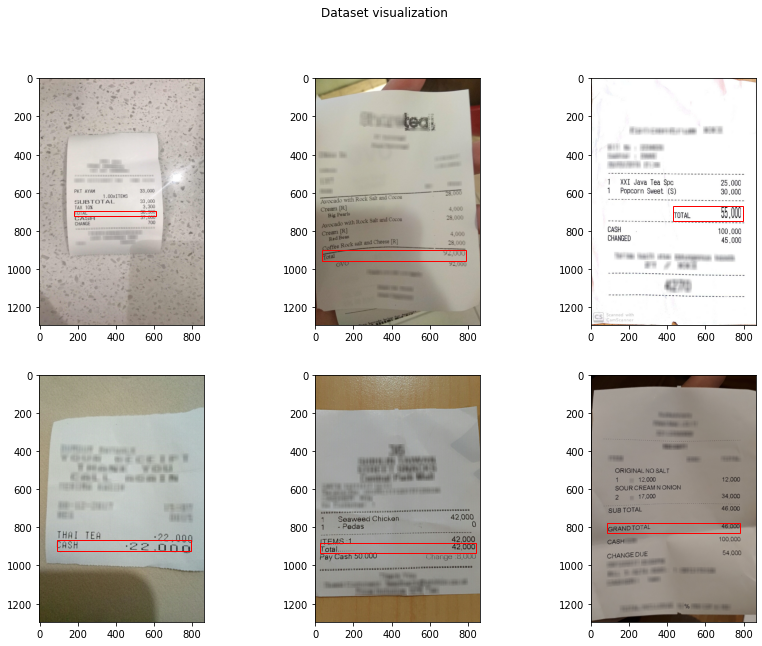

In [ ]:
new_shape = (1296, 864) # Image new shape

# image transformer consists of resizing to previous shape and transforming to channel-first format with 0-1 range pixels
img_transform = transforms.Compose([transforms.Resize(size=new_shape),
                                    transforms.ToTensor()])

# TTC bounding box transformer consists of resizing the bounding box according to the new image shape
bb_transform = BoundingBoxRescale(new_shape=new_shape)

# creating a temporary dataset and dataloader
ds = CORDataset(root_data_dir='./data', subset='train', img_transform=img_transform, bb_transform=bb_transform)
data_loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=0)


def visualize_dataset(dataset, n_rows, n_columns):
    """ Visualize n_rows * n_columns elements of the dataset with TTC bouding boxes """

    np.random.seed(50)
    indexes = np.random.randint(0, len(dataset), n_rows * n_columns)
    
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(14, 10))

    for idx, sample_idx in enumerate(indexes):
        img, bb = dataset[sample_idx]
        bb = bb["boxes"][0]
        img = transforms.ToPILImage()(img)
        axs[idx // n_columns, idx % n_columns].imshow(img)

        bb = Rectangle(xy=(bb[0], bb[1]), width=bb[2] - bb[0],
                                height=bb[3] - bb[1], 
                                linewidth=1, edgecolor='r', facecolor='none')
        
        axs[idx // n_columns, idx % n_columns].add_patch(bb)
    plt.suptitle('Dataset visualization')
    plt.show()      

# visualize 6 elements
visualize_dataset(dataset=ds, n_rows=2, n_columns=3)

# remove temporary dataset and dataloader
del ds
del data_loader

#### (downloading and) Defining the Faster R-CNN model with its ResNet-50 FPN Backbone 

In [ ]:
# load the ResNet-50 FPN backbone model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # background and TTC Bouding Box

# get number of input features for the classifier (ResNet)
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one and create the Fast R-CNN model
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#### Fine tune the network using a simple train/test approach
Params used:
* Optimizer: SGD with decay learning rate with initial value of 0.005, a momentum of 0.9 and L2 penalty with a factor of 0.0005 to avoid overfitting.
* Batch size of length 14 (max possible using 16GB Google Colab's GPU)
* 5 epochs training is enough to have good predictions.

Most hyper parameters are taken from PyTorch website and since they gave decent results, I didn't have to fine tune them.

In [ ]:
# a callback function to change how pytorch handles batch creation (necessary for Faster R-CNN target variables)
def collate_fn(batch):
    return tuple(zip(*batch))

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# use our dataset and defined transformations
dataset = CORDataset(root_data_dir='data', subset='train', img_transform=img_transform, bb_transform=bb_transform)
dataset_test = CORDataset(root_data_dir='data', subset='test', img_transform=img_transform, bb_transform=bb_transform)

# define training and validation data loaders
train_data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=14, shuffle=True, num_workers=4, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=14, shuffle=False, num_workers=4, collate_fn=collate_fn)

# push model to selected device
model.to(device)

# construct SGD optimizer 
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# construct SGD optimizer the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# train for 5 epochs
num_epochs = 6

for epoch in range(num_epochs):

    # train for one epoch, printing every 100 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch: [0]  [ 0/58]  eta: 0:07:38  lr: 0.000093  loss: 0.1650 (0.1650)  loss_classifier: 0.0355 (0.0355)  loss_box_reg: 0.0241 (0.0241)  loss_objectness: 0.0164 (0.0164)  loss_rpn_box_reg: 0.0890 (0.0890)  time: 7.9072  data: 5.0783  max mem: 14868
Epoch: [0]  [57/58]  eta: 0:00:02  lr: 0.005000  loss: 0.1643 (0.1626)  loss_classifier: 0.0355 (0.0366)  loss_box_reg: 0.0246 (0.0258)  loss_objectness: 0.0127 (0.0124)  loss_rpn_box_reg: 0.0863 (0.0879)  time: 2.2291  data: 0.0505  max mem: 14868
Epoch: [0] Total time: 0:02:20 (2.4141 s / it)
creating index...
index created!
Test:  [0/8]  eta: 0:00:31  model_time: 0.9806 (0.9806)  evaluator_time: 0.0346 (0.0346)  time: 3.9089  data: 2.7185  max mem: 14868
Test:  [7/8]  eta: 0:00:01  model_time: 0.8128 (0.7690)  evaluator_time: 0.0105 (0.0169)  time: 1.3340  data: 0.4605  max mem: 14868
Test: Total time: 0:00:10 (1.3483 s / it)
Averaged stats: model_time: 0.8128 (0.7690)  evaluator_time: 0.0105 (0.0169)
Accumulating evaluation results...
DO

##### Comments
---
4, 5 epochs are enough to obtain good performances (mainly loss_box_reg and loss_rpn_box_reg).  \\


----

#### Visualize model predictions
The function visualize_prediction is seeded inside!

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


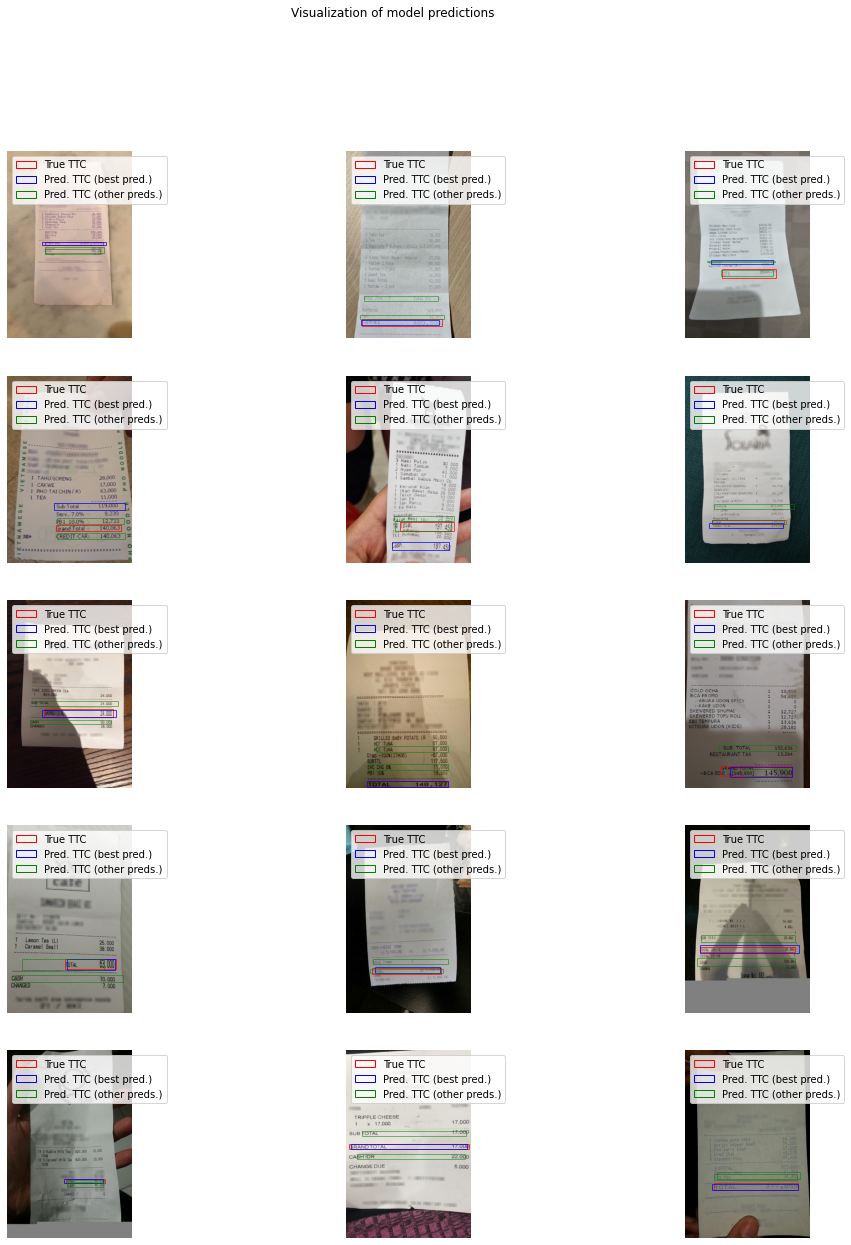

In [ ]:
def visualize_prediction(model, dataset, n_rows, n_columns, max_bbs):
    """ visualise n_rows * n_columns model predictions with max_bbs bouding boxes (including best prediction) """
    model.eval() # force model in eval mode

    np.random.seed(40)
    # np.random.seed(22)
    # np.random.seed(6)

    # get random indexes for plotting images
    indexes = np.random.randint(0, len(dataset), n_rows * n_columns)
    
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(17, 20))

    for idx, sample_idx in enumerate(indexes):
        img, true_bb = dataset[sample_idx] # get a random image and its TTC bounding box 
        true_bb = true_bb["boxes"][0]

        # predict for an image and copy the result from GPU to CPU
        pred_bbs = model([img.to(device)])[0]['boxes'].detach().cpu().numpy()

        # transform the PyTorch Tensor to PIL format (for matplotlib)
        img = transforms.ToPILImage()(img)

        axs[idx // n_columns, idx % n_columns].imshow(img)

        # create a rectangle for the bounding box
        true_bb = Rectangle(xy=(true_bb[0], true_bb[1]), width=true_bb[2] - true_bb[0],
                                height=true_bb[3] - true_bb[1], 
                                linewidth=1, edgecolor='red', facecolor='none', alpha=0.7)

        
        axs[idx // n_columns, idx % n_columns].add_patch(true_bb)

        # get prediction bouding boxes (sorted by the model confidence)
        for bb_idx in range(min(max_bbs, len(pred_bbs))):
            pred_bb = pred_bbs[bb_idx]

            # the best prediction in plotted in Blue, the rest in Green
            if bb_idx == 0:
                pred_bb = Rectangle(xy=(pred_bb[0], pred_bb[1]), width=pred_bb[2] - pred_bb[0],
                                        height=pred_bb[3] - pred_bb[1], 
                                        linewidth=1, edgecolor='blue', facecolor='none', alpha=0.7)
            else:
                pred_bb = Rectangle(xy=(pred_bb[0], pred_bb[1]), width=pred_bb[2] - pred_bb[0],
                                        height=pred_bb[3] - pred_bb[1], 
                                        linewidth=1, edgecolor='green', facecolor='none', alpha=0.5)
                
            axs[idx // n_columns, idx % n_columns].add_patch(pred_bb)

        legend_elements = [Patch(facecolor='none', edgecolor='red', 
                                label='True TTC'),
                          Patch(facecolor='none', edgecolor='blue',
                                label='Pred. TTC (best pred.)'),
                           Patch(facecolor='none', edgecolor='green', 
                                label='Pred. TTC (other preds.)')]

        axs[idx // n_columns, idx % n_columns].legend(handles=legend_elements, loc='upper left')
        axs[idx // n_columns, idx % n_columns].axis('off')

    plt.subplots_adjust(wspace=0.25, hspace=0.2)
    plt.suptitle('Visualization of model predictions')
    plt.show()      

# visualize predictions
visualize_prediction(model=model, dataset=dataset_test, n_rows=5, n_columns=3, max_bbs=3)

##### Comments
Even with few epochs, predictions seem pretty accurate, even when sometimes the blue (best) prediction is not the same as the true values it is still near and other predictions are close too. Which demonstrates the ability of the model to learn the underlying function to extract TTC from receipts.

#### What's next ?
The work presented in this notebook is relatively simplistic. One can imagine adding the following points: 

* Enlarge bounding boxes by a certain factor to better wrap the ROI.
* Augment Data (Rotation, translation etc.) and try training a model from scratch.
* Preprocess more the data (grey scale, constrast etc.)
* A more complex training phase: using Cross-Validation, adding early stopping, etc.
* Better visualizations of the train/test metrics (losses, precisions, IoU etc.) using tensorboard for example.
* Diving deeper in the data, and maybe removing some images instead of taking SUBTOTAL price (like what was done here).